# Simple 1/V estimator
Source: doi:10.1093/mnras/stw756 (page 7)

## Imports, initial values

In [610]:
import numpy as np
from astropy.coordinates import Distance
from astropy.table import Table, hstack
from astropy.cosmology import Planck18
from astropy.coordinates import Distance
from astropy import units as u
import astropy.constants as asc
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Complete Sky area in deg^2

In [611]:
omega_sky = 41253 #

In [612]:
min_ra = 160.0
min_dec = -8
max_ra = 180.0
max_dec = 2
buffer = 2.0

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 199.47 sqdeg


In [613]:
z_min_data = 0.02
z_max_data = 0.06

## Functions

define the functions that calculate the V_max & luminosity limit

In [614]:
def V_max(omega_s, z_min, z_max_lum):
    """
    Description: Calculates the maximum Volume in which the source could have been detected in: corrects for the so-called "Malmquist-bias"
    (faint objects, which usually also means low mass objects, will only be covered in a survey within a smaller volume than bright and high-mass
    objects)
    
    Params:
    omega_s: surface area covered by the complete data
    z_min: lower redshift limit of sample
    z_max_lum: maximum redshift determined for for object based on luminosity and its completeness 
    (i.e. maximum redshift at which the source with luminosity l would no longer be part of the sample)
    
    """
    z_max = min(z_max_data, z_max_lum)
    return 4/3*np.pi * omega_s/omega_sky * (Distance(z=z_max, cosmology=Planck18)**3-Distance(z=z_min, cosmology=Planck18)**3)

In [615]:
def lum_lim(lum, m_lim, m):
    """
    Calculate the luminosity a source would have if its magnitude was equal to the DESI magnitude limit (have to research the value)
    
    Params:
    - lum: luminosity of an object
    - m_lim: magnitude limit of the survey
    - m: apparent magnitude of an object
    
    """
    return lum*10**(-0.4*(m_lim-m))

## Load the data & prepare/select

In [616]:
# Release directory path

specprod = 'iron'    # Internal name for most current data release
specprod_dir = '/global/cfs/cdirs/desi/spectro/redux/iron/'
print(specprod_dir)

/global/cfs/cdirs/desi/spectro/redux/iron/


In [617]:
ztile_cat = Table.read(f'{specprod_dir}/zcatalog/zall-tilecumulative-{specprod}.fits', hdu="ZCATALOG")

In [618]:
ztile_cat.keep_columns(['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'TARGET_RA', 'TARGET_DEC', 'FLUX_Z', 'FLUX_R', 'LASTNIGHT'])

In [619]:
ztile_cat = ztile_cat[ztile_cat["PROGRAM"] == "bright"]

In [620]:
len(ztile_cat)

12782500

In [621]:
ztile_cat = ztile_cat[ztile_cat['ZWARN']==0]

In [622]:
ztile_cat = ztile_cat[ztile_cat['Z']>=0]

In [623]:
ztile_cat = ztile_cat[ztile_cat["FLUX_Z"] > 0.0]

In [624]:
ztile_cat = ztile_cat[ztile_cat["FLUX_R"] > 0.0]

In [625]:
ii = ztile_cat['TARGET_RA']>(min_ra)
ii &= ztile_cat['TARGET_RA']<(max_ra)
ii &= ztile_cat['TARGET_DEC']>(min_dec)
ii &= ztile_cat['TARGET_DEC']<(max_dec)

ztile_cat = ztile_cat[ii]

### Calculate the apparent and absolute magnitudes from the given Fluxes (app mag both r and z-band flux, to correct the z limit() with a Planck Cosmology

In [626]:
# calculate the absolute and apparent magnitude of every galaxy (Planck Cosmology)
app_mag = [22.5-2.5*np.log10(ztile_cat["FLUX_Z"][q]) for q in range(len(ztile_cat["FLUX_Z"]))]
app_mag_r = [22.5-2.5*np.log10(ztile_cat["FLUX_R"][q]) for q in range(len(ztile_cat["FLUX_R"]))]

abs_mag = [(app_mag[q] - 5*np.log10(Distance(z=ztile_cat["Z"][q], cosmology=Planck18)/u.Mpc*10**6)+5).value for q in range(len(ztile_cat["FLUX_Z"]))]

In [627]:
diff = [app_mag_r[q]-app_mag[q] for q in range(len(app_mag))]

In [628]:
avg_diff = np.mean(diff)

In [629]:
avg_diff

0.6133449566481914

In [630]:
# However, since we only look at the z-band we need to correct the solar luminosity
# Calculation from here: https://astronomy.stackexchange.com/questions/25126/how-to-calculate-luminosity-in-g-band-from-absolute-ab-magnitude-and-luminosity
lmbda = 900*10**(-9) #in  m
del_lambda = 152*10**(-9) #in m
del_v = (asc.c*lmbda/(del_lambda**2)).value # this is in /s now
print(del_v)

m_sun = -27.74 # in z-band: http://mips.as.arizona.edu/~cnaw/sun.html

f_v = 10**((-48.6-m_sun)/2.5) # in erg/(cm^2 s Hz)
print(f_v)
dist_sun = 1.496*10**13 # in cm

L_sun_z = f_v*del_v*4*np.pi*dist_sun**2 # this is  in erg/s, convert to W in function declaration
# the value is roughly half of the full bolometric value... not sure if this makes sense
print(L_sun_z)

def lum_z(M):
    return L_sun_z*10**(-7)*np.exp(-0.4*M)*u.W

1.1678203436634348e+16
4.528975799036195e-09
1.4874729870531035e+35


In [631]:
lums = [lum_z(abs_mag[q]).value for q in range(len(abs_mag))]

In [632]:
offset = 0.35

In [633]:
m_limit = 19.5-avg_diff+offset # r-band magnitude limit for BGS Bright, would need to convert it to z-band magnitude

In [634]:
lumin_limits = [lum_lim(lums[q], m_limit, app_mag[q]) for q in range(len(ztile_cat["FLUX_Z"]))]

In [635]:
ztile_cat = hstack([ztile_cat, Table({'APP_MAG': app_mag}), Table({"LUM_Z": lums}), Table({'LUM_LIMIT': lumin_limits})])

In [636]:
ztile_cat

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_R,FLUX_Z,APP_MAG,LUM_Z,LUM_LIMIT
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32,float32,float64,float64,float64
39627775337825719,main,bright,20211203,0.00014289519679614772,1.2174297055299621e-05,0,160.31888038038957,-0.6110339412089351,41.54377,44.649815,18.37545096874237,1.4154125430544787e+29,6.403264034643386e+28
39627775337824625,main,bright,20211203,0.13764590720371164,3.138398346518236e-05,0,160.26516984509954,-0.6169891390880035,51.795795,107.864204,17.417806386947632,8.8083943280508e+31,1.649518862105314e+31
39627769298028466,main,bright,20211203,0.2817386734692243,3.1591015286591765e-05,0,160.32678007762797,-0.7009874345328915,13.230762,27.53629,18.90023648738861,9.739547617157093e+31,7.144492140946009e+31
39627775333634331,main,bright,20211203,0.13458266255484935,2.6267345434881147e-05,0,160.22171516984815,-0.6094808182128068,17.924074,42.162964,18.4376722574234,5.734703899274961e+31,2.747374635840003e+31
39627781373430673,main,bright,20211203,0.4109369476208085,3.120556476874701e-05,0,160.12321667256924,-0.19389775125634237,20.778055,42.091717,18.439508378505707,1.7144933886639667e+32,8.227675387319e+31
39627769298026862,main,bright,20211203,0.13299025612216608,7.00164724165495e-05,0,160.26156628507124,-0.7357844162293757,20.583942,37.838287,18.555171191692352,5.41040914372244e+31,2.8882618757700265e+31
39627787413227120,main,bright,20211203,0.13477296048907014,3.583645968152769e-06,0,160.07077291874026,-0.01671600137374464,32.528183,43.264362,18.409674167633057,5.807016244700645e+31,2.7111945989183196e+31
39627775333633000,main,bright,20211203,7.31711111071119e-05,1.2927234659651214e-06,0,160.15556595175855,-0.6126349523232263,315.19934,385.6764,16.03444218635559,2.0186362698345015e+29,1.0572384014559742e+28
39627769298027878,main,bright,20211203,0.1919126971419605,2.206269425513075e-05,0,160.30116444104704,-0.6576801019874786,32.69794,69.04125,17.902228236198425,9.965448320104339e+31,2.9155877605212237e+31


In [757]:
ztile_cat_grouped_by_AppMag = ztile_cat.group_by("APP_MAG")

In [758]:
ztile_cat_grouped_by_AppMag

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_R,FLUX_Z,APP_MAG,LUM_Z,LUM_LIMIT
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32,float32,float64,float64,float64
39627775383962259,main,bright,20220125,0.018489484996358396,6.242243193662295e-06,0,163.02823562899832,-0.5607419927477143,10511.668,19817.61,11.757371425628662,1.380934024167512e+32,1.407535907899002e+29
39627817926789729,sv3,bright,20210501,0.006278844365059559,3.0186676457452016e-06,0,178.9038960898141,1.2371578580532396,11897.791,18113.543,11.854991912841797,5.156328797199572e+31,5.750099376450717e+28
39627763434393910,main,bright,20220202,0.01884878430960053,9.946314888937158e-06,0,170.9436223267531,-1.104878583445848,8778.258,15983.1875,11.990841627120972,1.2793111399054456e+32,1.6167795790706977e+29
39627720979645506,main,bright,20220227,0.02115116431047287,7.86234499620044e-06,0,160.3045942048227,-2.8029570097101137,8067.524,15674.259,12.012032270431519,1.4041546545270105e+32,1.8095301963232092e+29
39627721294217343,main,bright,20211212,0.020173958729398204,5.5556755928304535e-06,0,179.00441204366481,-2.7208461390200833,8954.348,15597.029,12.017395496368408,1.3438960435471868e+32,1.740451223406668e+29
39627733268958032,main,bright,20220428,0.01584032838588673,5.302003869818911e-06,0,172.8836800865466,-2.3091760430601673,9700.66,15335.652,12.035744190216064,1.078283362461829e+32,1.4202623126766224e+29
39627660984324241,main,bright,20220407,0.019119827586109334,8.284943482550257e-06,0,178.4530870471462,-5.1678805923382045,7900.303,15134.842,12.050055265426636,1.2651782293862518e+32,1.688541733487149e+29
39627600926084799,main,bright,20220213,0.018986635228373155,3.403141278917982e-06,0,178.65697479273229,-7.756576709815696,8566.475,15015.009,12.058686017990112,1.2530775533272084e+32,1.6857390226942176e+29
39627769482579342,main,bright,20220202,0.02531639952438768,7.792468547635792e-06,0,171.39615503521094,-0.7682239149074916,7639.28,13545.4795,12.17051386833191,1.5447426958196334e+32,2.3035608047008165e+29


In [759]:
# this makes a z selection!
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[ztile_cat_grouped_by_AppMag["Z"]< 0.6]

In [760]:
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[::-1]

In [761]:
ztile_cat_grouped_by_AppMag[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_R,FLUX_Z,APP_MAG,LUM_Z,LUM_LIMIT
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32,float32,float64,float64,float64
39627775388156785,main,bright,20220127,0.00020695404787949559,6.570050538091658e-05,0,163.28102362702234,-0.4756075976427871,4.2519755,2.2324362,21.62805236876011,5.315998210485212e+28,4.809985378947641e+29
39627757537201972,sv3,bright,20210501,0.0005217900481360108,0.0004466572379209556,0,179.43978746157867,-1.2627589866856481,4.3830676,2.2673552,21.611201092600822,1.1952190584343763e+29,1.0647948189511858e+30
39627763564414305,sv1,bright,20210322,1.833540347017401e-05,1.2036400593475272e-06,0,178.5730568090677,-0.9034542729081607,93.8796,2.4019334,21.54859758913517,6.684526150701191e+27,5.62144084573701e+28
39627799807395030,sv3,bright,20210502,0.00040888931032501347,0.0002176825569226886,0,178.8125189692347,0.5496678436220963,4.5848966,2.6996517,21.421730667352676,1.0431682287713553e+29,7.80521015843115e+29
39627799807395030,sv3,bright,20210410,0.00010157326644134223,0.00021311762484762438,0,178.8125189692347,0.5496678436220963,4.5848966,2.6996517,21.421730667352676,3.111143420511302e+28,2.3278247515946437e+29


In [762]:
ztile_cat_grouped_by_AppMag_sel = ztile_cat_grouped_by_AppMag[:int(0.2*len(ztile_cat_grouped_by_LumLim))]

In [763]:
ztile_cat_grouped_by_AppMag_sel[:5], len(ztile_cat_grouped_by_LumLim_sel), len(ztile_cat_grouped_by_LumLim)

(<Table length=5>
      TARGETID     SURVEY ...         LUM_Z                LUM_LIMIT       
       int64       bytes7 ...        float64                float64        
 ----------------- ------ ... ---------------------- ----------------------
 39627775388156785   main ...  5.315998210485212e+28  4.809985378947641e+29
 39627757537201972    sv3 ... 1.1952190584343763e+29 1.0647948189511858e+30
 39627763564414305    sv1 ...  6.684526150701191e+27   5.62144084573701e+28
 39627799807395030    sv3 ... 1.0431682287713553e+29   7.80521015843115e+29
 39627799807395030    sv3 ...  3.111143420511302e+28 2.3278247515946437e+29,
 149804,
 749020)

In [764]:
lower_limit_z = np.min(ztile_cat_grouped_by_AppMag["Z"]) # np.min(faint_mags["Z"]) # get the limits of redshift in this sample
upper_limit_z = np.max(ztile_cat_grouped_by_AppMag["Z"]) # np.max(faint_mags["Z"])
delta_z = 0.005
bins = np.arange(lower_limit_z, upper_limit_z, delta_z)
num_of_bins_z = len(bins)

In [765]:
lower_limit_z, upper_limit_z, num_of_bins_z

(6.856555987640881e-09, 0.5999922744556289, 120)

In [766]:
LUM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin
LUM_LIM_95 = [0 for x in range(num_of_bins_z-1)] # this will be the array in which we store the mass limit of each bin



cnt = 0
for bins_left_edge in bins[:num_of_bins_z-1]:
    # this is where we select all the galaxies that lie in the z range ([start, stop))
    #print(bins_left_edge, bins_left_edge + delta_z)
    
    ii = ztile_cat_grouped_by_AppMag_sel['Z']>=(bins_left_edge)
    ii &= ztile_cat_grouped_by_AppMag_sel['Z']<(bins_left_edge+delta_z)
    dat = ztile_cat_grouped_by_AppMag_sel[ii]
    #dat = ztile_cat_grouped_by_LumLim_sel[bins_left_edge <= ztile_cat_grouped_by_LumLim_sel["Z"]] and ztile_cat_grouped_by_LumLim_sel[ztile_cat_grouped_by_LumLim_sel["Z"] < bins_left_edge + delta_z]
    # next we sort the data (ascending, i.e. the highest luminosity is the last one)
    #print(dat)
    LUM = dat["LUM_Z"]
    LUM_LIM = dat["LUM_LIMIT"]
    #print(dat)
    LUM = np.sort(LUM)
    LUM_LIM = np.sort(LUM_LIM)
    #print("sorted", dat)
    #dat = dat[::-1]
    #print(dat)
    
    # impose the same cut as in the paper, at 95%. This is the mass limit value
    LUM_cut = int(0.95*len(LUM))
    LUM_LIM_cut = int(0.95*len(LUM_LIM))

    #print(cut)
    if len(LUM) == 0:
        LUM = [0]
    if len(LUM_LIM) == 0:
        LUM_LIM = [0]
    
    # now store this luminosity value
    LUM_95[cnt] = LUM[LUM_cut] # this is the mass limit in each bin, to which we now need to fit the 2nd order poly
    LUM_LIM_95[cnt] = LUM_LIM[LUM_LIM_cut] # this is the mass limit in each bin, to which we now need to fit the 2nd order poly
    #print(array)
    cnt += 1
    #print(cnt)
    #ztile_cat_grouped_by_AppMag_sel[bins_left_edge <= ztile_cat_grouped_by_AppMag_sel["Z"]] and ztile_cat_grouped_by_AppMag_sel[ztile_cat_grouped_by_AppMag_sel["Z"] < bins_left_edge + delta_z]

In [767]:
np.count_nonzero(array), len(array)

(452, 999)

In [768]:
stop_at = np.argmin(LUM_LIM_95)

In [769]:
stop_at

0

[-1156.01699719 27702.2762789    107.48243572]
[ 8500.21185842 19971.84326933   664.67965644]


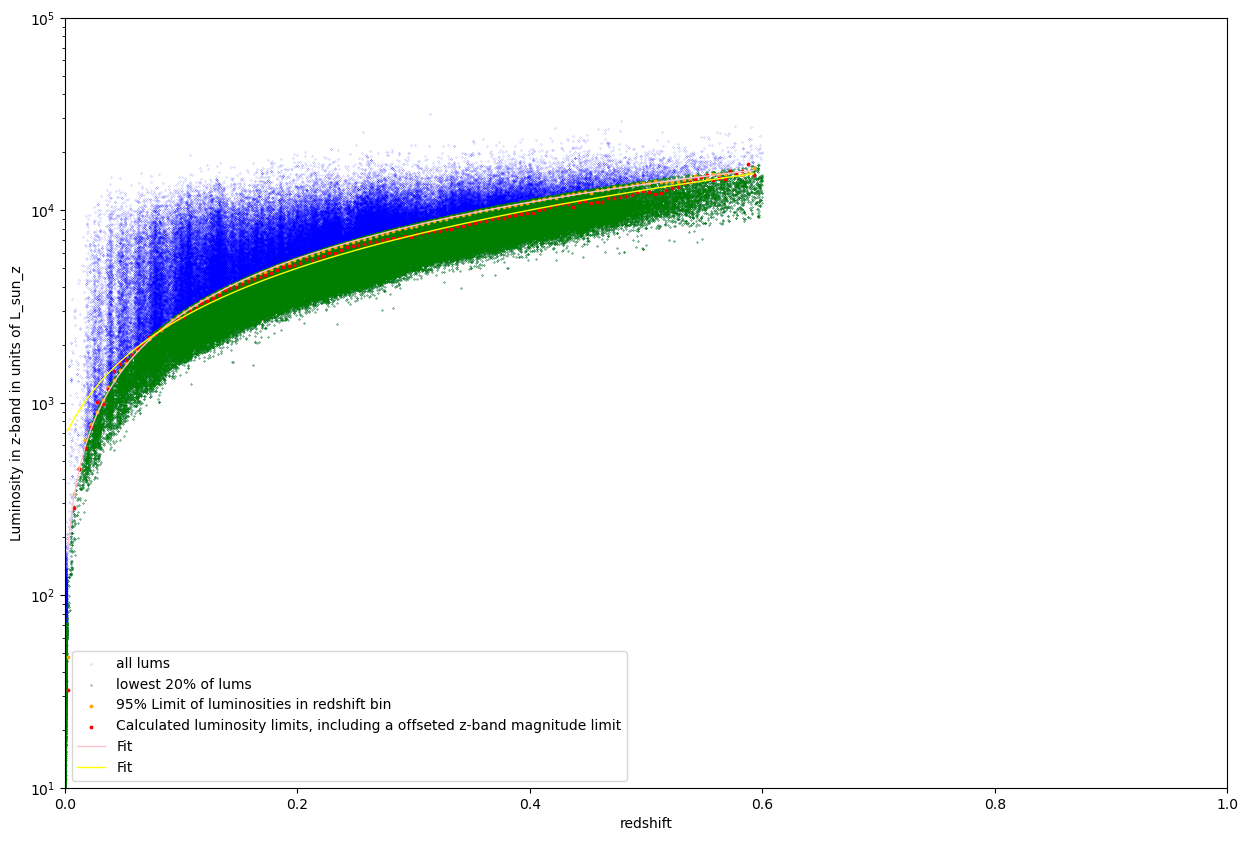

In [770]:
fig, ax = plt.subplots(figsize = (15,10))

ax.scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_Z"]/(L_sun_z*10**(-7)), s = 0.01, color = "blue", label = "all lums")

ax.scatter(ztile_cat_grouped_by_AppMag_sel["Z"], ztile_cat_grouped_by_AppMag_sel["LUM_Z"]/(L_sun_z*10**(-7)), s = 0.1, color = "green", label ="lowest 20% of lums")

center_z = (bins[:-1] + bins[1:])/2
ax.scatter(center_z, LUM_95/(L_sun_z*10**(-7)), s = 3, color = "orange", label ="95% Limit of luminosities in redshift bin")
ax.scatter(center_z, LUM_LIM_95/(L_sun_z*10**(-7)), s = 3, color = "red", label ="Calculated luminosity limits, including a offseted z-band magnitude limit")

def poly2d(x, a, b, c):
    return a*x**2 + b*x + c

# we want to cut off where the data gets bad, i.e. where we have the first 0, therefore in the fitting procedure we only select the values up to the first 0
coefs_LUM_95, _ = curve_fit(poly2d, center_z[:stop_at-1], LUM_95[:stop_at-1]/(L_sun_z*10**(-7)))
coefs_LUM_LIM_95, _ = curve_fit(poly2d, center_z[:stop_at-1], LUM_LIM_95[:stop_at-1]/(L_sun_z*10**(-7)))
#coefs_log, _ = curve_fit(log10_fit, center_z, LUM_LIM_95/(L_sun_z*10**(-7)))

print(coefs_LUM_95)
print(coefs_LUM_LIM_95)

ax.plot(center_z, poly2d(center_z, *coefs_LUM_95), linewidth = 1, color = "pink", label = "Fit")
ax.plot(center_z, poly2d(center_z, *coefs_LUM_LIM_95), linewidth = 1, color = "yellow", label = "Fit")



#ax.plot(center_z, log10_fit(center_z, *coefs_log), linewidth = 1, color = "yeelow", label = "DATA")


ax.set_xlabel("redshift")
ax.set_ylabel("Luminosity in z-band in units of L_sun_z")
ax.set_yscale("log")
ax.set_xlim(0,1)
ax.set_ylim(10,10**5)
ax.legend()
plt.show()

invert to get zmax

$$ax^2+bx+c = a(x-h)^2+k$$ with $$h = -\frac{b}{2a} \text{ and } k = c-ah^2$$

i.e. the inverse of a quadratic is:

$$ f^{-1}(x) = \pm\sqrt{\frac{x-k}{a}}+h$$

To reproduce the physically correct results one has to take the negative solution!

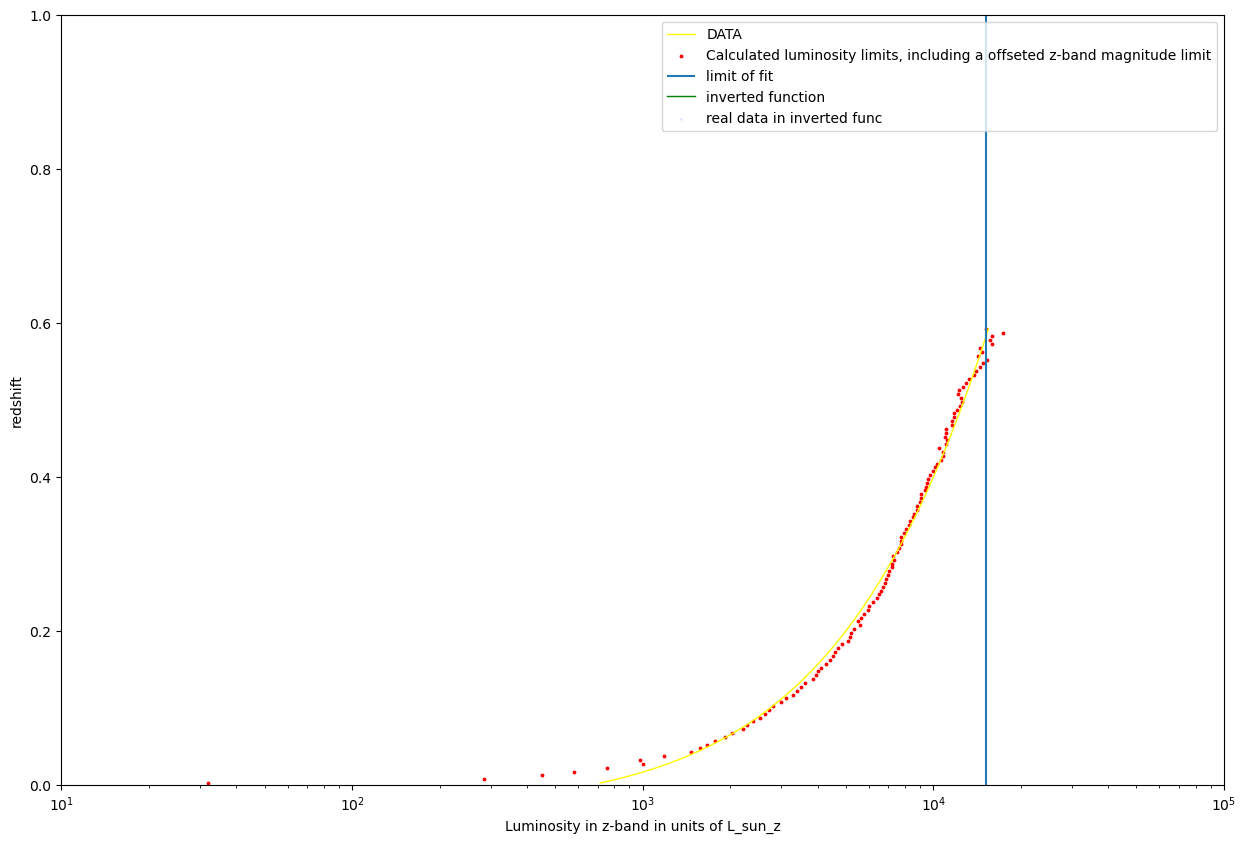

In [771]:
# now plot the inverse:

# from here we can get the z_max values, i.e. the maximum redshift at a certain luminosity that an object could be detected

# inverse is as above

def poly_inverse(x, a,h,k):
    return -np.sqrt((x-k)/a)+h


a = coefs_LUM_LIM_95[0]
b = coefs_LUM_LIM_95[1]
c = coefs_LUM_LIM_95[2]
h = -b/(2*a)
k = c-a*h**2
inverted_coefs_95 = [a,h,k]

fig, ax = plt.subplots(figsize = (15,10))

ax.plot(poly2d(center_z, *coefs_LUM_LIM_95), center_z, linewidth = 1, color = "yellow", label = "DATA")
ax.scatter(LUM_LIM_95/(L_sun_z*10**(-7)), center_z, s = 3, color = "red", label ="Calculated luminosity limits, including a offseted z-band magnitude limit")
ax.vlines(LUM_LIM_95[stop_at-1]/(L_sun_z*10**(-7)), 0, 1, label = "limit of fit")

ax.plot(LUM_LIM_95[:stop_at-1]/(L_sun_z*10**(-7)), poly_inverse(LUM_LIM_95[:stop_at-1]/(L_sun_z*10**(-7)), *inverted_coefs_95), linewidth = 1, color = "green", label = "inverted function")
ax.scatter(ztile_cat_grouped_by_AppMag["LUM_Z"]/(L_sun_z*10**(-7)), poly_inverse(ztile_cat_grouped_by_AppMag["LUM_Z"]/(L_sun_z*10**(-7)), *inverted_coefs_95), s= 0.01, color = "blue", label = "real data in inverted func")



ax.set_xlabel("Luminosity in z-band in units of L_sun_z")
ax.set_ylabel("redshift")
ax.set_xscale("log")
ax.set_ylim(0,1)
ax.set_xlim(10,10**5)
ax.legend()
plt.show()

In [772]:
V_max_i = [V_max(area, np.min(ztile_cat_grouped_by_AppMag["Z"]), poly_inverse(ztile_cat_grouped_by_AppMag["LUM_Z"][q]/(L_sun_z*10**(-7)), *inverted_coefs_95)) for q in range(len(ztile_cat_grouped_by_AppMag))]

/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/astropy/cosmology/flrw/base.py:1130: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]


In [773]:
len(V_max_i)

311175

In [774]:
len(ztile_cat_grouped_by_AppMag)

311175

In [775]:
V_max_i[:5]

[<Quantity nan Mpc3>,
 <Quantity nan Mpc3>,
 <Quantity nan Mpc3>,
 <Quantity nan Mpc3>,
 <Quantity nan Mpc3>]

In [776]:
ztile_wVmax = hstack([ztile_cat_grouped_by_AppMag, Table({"V_MAX": V_max_i})])

In [777]:
ztile_wVmax[:5]

TARGETID,SURVEY,PROGRAM,LASTNIGHT,Z,ZERR,ZWARN,TARGET_RA,TARGET_DEC,FLUX_R,FLUX_Z,APP_MAG,LUM_Z,LUM_LIMIT,V_MAX
,,,,,,,,,,,,,,Mpc3
int64,bytes7,bytes6,int32,float64,float64,int64,float64,float64,float32,float32,float64,float64,float64,float64
39627775388156785,main,bright,20220127,0.00020695404787949559,6.570050538091658e-05,0,163.28102362702234,-0.4756075976427871,4.2519755,2.2324362,21.62805236876011,5.315998210485212e+28,4.809985378947641e+29,nan
39627757537201972,sv3,bright,20210501,0.0005217900481360108,0.0004466572379209556,0,179.43978746157867,-1.2627589866856481,4.3830676,2.2673552,21.611201092600822,1.1952190584343763e+29,1.0647948189511858e+30,nan
39627763564414305,sv1,bright,20210322,1.833540347017401e-05,1.2036400593475272e-06,0,178.5730568090677,-0.9034542729081607,93.8796,2.4019334,21.54859758913517,6.684526150701191e+27,5.62144084573701e+28,nan
39627799807395030,sv3,bright,20210502,0.00040888931032501347,0.0002176825569226886,0,178.8125189692347,0.5496678436220963,4.5848966,2.6996517,21.421730667352676,1.0431682287713553e+29,7.80521015843115e+29,nan
39627799807395030,sv3,bright,20210410,0.00010157326644134223,0.00021311762484762438,0,178.8125189692347,0.5496678436220963,4.5848966,2.6996517,21.421730667352676,3.111143420511302e+28,2.3278247515946437e+29,nan


In [778]:
lower_limit_lum = np.min(ztile_wVmax["LUM_Z"])
upper_limit_lum = np.max(ztile_wVmax["LUM_Z"])
print("lower and upper limit of LUM_Z: ", lower_limit_lum, upper_limit_lum)

num_of_lum_bins = 1000

lum_bins = np.logspace(np.log10(lower_limit_lum), np.log10(upper_limit_lum), num_of_lum_bins, endpoint = True)

print("num of bins", len(lum_bins))
print(lum_bins[0:10])

lower and upper limit of LUM_Z:  3.7911833037122523e+25 4.716929249585151e+32
num of bins 1000
[3.79118330e+25 3.85368994e+25 3.91722715e+25 3.98181192e+25
 4.04746153e+25 4.11419352e+25 4.18202575e+25 4.25097635e+25
 4.32106377e+25 4.39230674e+25]


In [779]:
len(lum_bins)

1000

In [780]:
def calc_phi_j(V_max_i, lum_bins):
    
    
    phi_j = [0 for q in range(len(lum_bins)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["LUM_Z"] >= lum_bins[q]
        ii &= ztile_wVmax["LUM_Z"]< lum_bins[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX"]
        one_ov_dat = [1/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

In [781]:
phi_j = calc_phi_j(V_max_i, lum_bins)

In [782]:
len(phi_j)

999

In [783]:
phi_j[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [784]:
center_lum_bins = lum_bins[1:]-lum_bin_size/2

In [785]:
len(center_lum_bins)

999

/tmp/ipykernel_137875/741966550.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


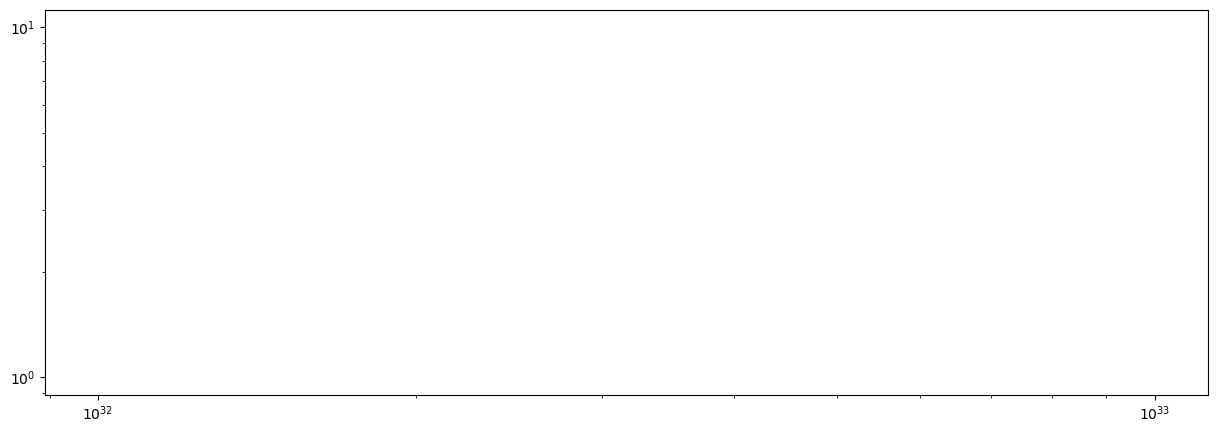

In [786]:
fig, ax = plt.subplots(figsize = (15,5))


ax.scatter(center_lum_bins, phi_j, s = 5)
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()

In [787]:
np.logspace(-2, 5, 8)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])